In [2]:
import numpy as np 
import pandas as pd 
import os
from matplotlib import pyplot as plt
import torch
import cv2
from pathlib import Path

In [3]:
import os
from shapely.geometry import Polygon, box
import json
import pyproj
from rasterio.mask import mask    
import rasterio 
def crs_transform(x,y, input_crs=4326, target_crs=32630):
        transformer = pyproj.Transformer.from_crs(pyproj.CRS.from_epsg(input_crs), pyproj.CRS.from_epsg(target_crs), always_xy=True)
        reprojected_x , reprojected_y = transformer.transform(x, y)
        return reprojected_x, reprojected_y
 
 
def convert_all_points(ls_ls, input_crs=4326, target_crs=32630):
    """ convert points to crs of geotiff image"""
    t_t = []
    for i in ls_ls:
        l = list(crs_transform(i[0], i[1], input_crs, target_crs))
        #l.append(i[2])
        t_t.append(l)
    return t_t
 
 
def get_intersection_percentage(reprojected_polygon, geobox):
    return reprojected_polygon.intersection(geobox).area / reprojected_polygon.area
 

In [4]:
def get_image_with_highest_intersection(geojson_file_path, root_dir):
    with open(geojson_file_path, "r") as f:
        geojson_file = json.load(f)

    #print(geojson_file['features'])
   
    geojson_points_unprojected = geojson_file['features'][0]['geometry']['coordinates'][0]
    #print(geojson_points_unprojected)
 
    #print(geojson_points_unprojected)
    best_match = None
    best_match_percentage = 0
    tif_files = [file for file in Path(root_dir).iterdir() if file.suffix in ['.tif', '.tiff']]
    #print(tif_files)
    # for each image for the geojson file
    for image_path in tif_files:
        #image_path = os.path.join(dir_path, tif_file)
        #print(image_path)
        with rasterio.open(image_path) as src:
            image_geometry = box(*src.bounds)
            crs = f"{src.crs}"
            crs = int(crs.split(":")[-1])
            reprojected_points = convert_all_points(geojson_points_unprojected,target_crs=crs)
           
            reprojected_polygon = Polygon(reprojected_points)
            #print(reprojected_points)
        intersection_percentage = get_intersection_percentage(reprojected_polygon, image_geometry)
        if (intersection_percentage > best_match_percentage) and (intersection_percentage < 0.8):
            best_match_percentage = intersection_percentage
            best_match = image_path

    return geojson_file_path, best_match.as_posix(), best_match_percentage
 


In [5]:
geo_json_path = "/home/idisc02/Saarland_Forest_monitoring_research/Reforestation_Monitoring/Plant_For_Planet_above200_dataset/polygon_7.geojson"
polygon_name = "polygon_7"
# Directory path
root_dir = f"/home/idisc02/Saarland_Forest_monitoring_research/Reforestation_Monitoring/Plant_For_Planet_above200_dataset/{polygon_name}/1b146699-0721-4fc8-a15d-e7ce221cc7fd/PSScene"

geojson_file, match_image_path, _ = get_image_with_highest_intersection(geo_json_path, root_dir)
print(_)


0.787955096883202


In [6]:
def get_masked_region(geojson_file, image_path):
    with open(geojson_file, "r") as f:
        geojson_file = json.load(f)
   
    geojson_points_unprojected = geojson_file['features'][0]['geometry']['coordinates'][0]
 
    with rasterio.open(image_path) as src:
        #image_geometry = box(*src.bounds)
        crs = f"{src.crs}"
        crs = int(crs.split(":")[-1])
       
        # Mask the image
        reprojected_points = convert_all_points(geojson_points_unprojected,target_crs=crs)
           
        reprojected_polygon = Polygon(reprojected_points)
        out_image, out_transform = rasterio.mask.mask(src, [reprojected_polygon], crop=True)
 
        out_meta = src.meta.copy()
 
        out_meta.update({
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform
        })
 
        save_path = "/home/idisc02/Saarland_Forest_monitoring_research/Reforestation_Monitoring/Plant_For_Planet_above200_dataset/polygon_7/1b146699-0721-4fc8-a15d-e7ce221cc7fd"
        # Write the masked image to a new file
        with rasterio.open(f'{save_path}/masked_image.tif', 'w', **out_meta) as dest:
            dest.write(out_image)

In [7]:
get_masked_region(geojson_file, match_image_path)

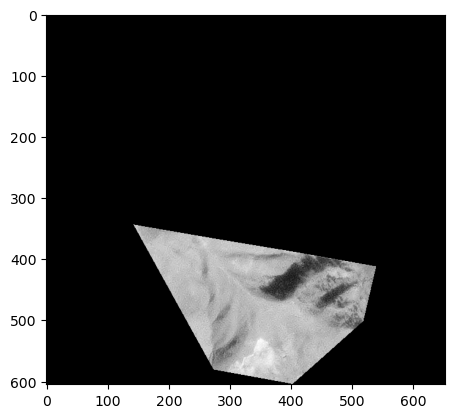

In [8]:
import matplotlib.pyplot as plt
import rasterio

# Open the image file
with rasterio.open('/home/idisc02/Saarland_Forest_monitoring_research/Reforestation_Monitoring/Plant_For_Planet_above200_dataset/polygon_7/1b146699-0721-4fc8-a15d-e7ce221cc7fd/masked_image.tif') as src:
    img = src.read(1)  # read the first band of the image

# Display the image
plt.imshow(img, cmap='gray')
plt.show()

In [9]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "/home/idisc02/Saarland_Forest_monitoring_research/Reforestation_Monitoring/model_vit-b.pth"
model_type = "vit_b"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam, points_per_batch=16)

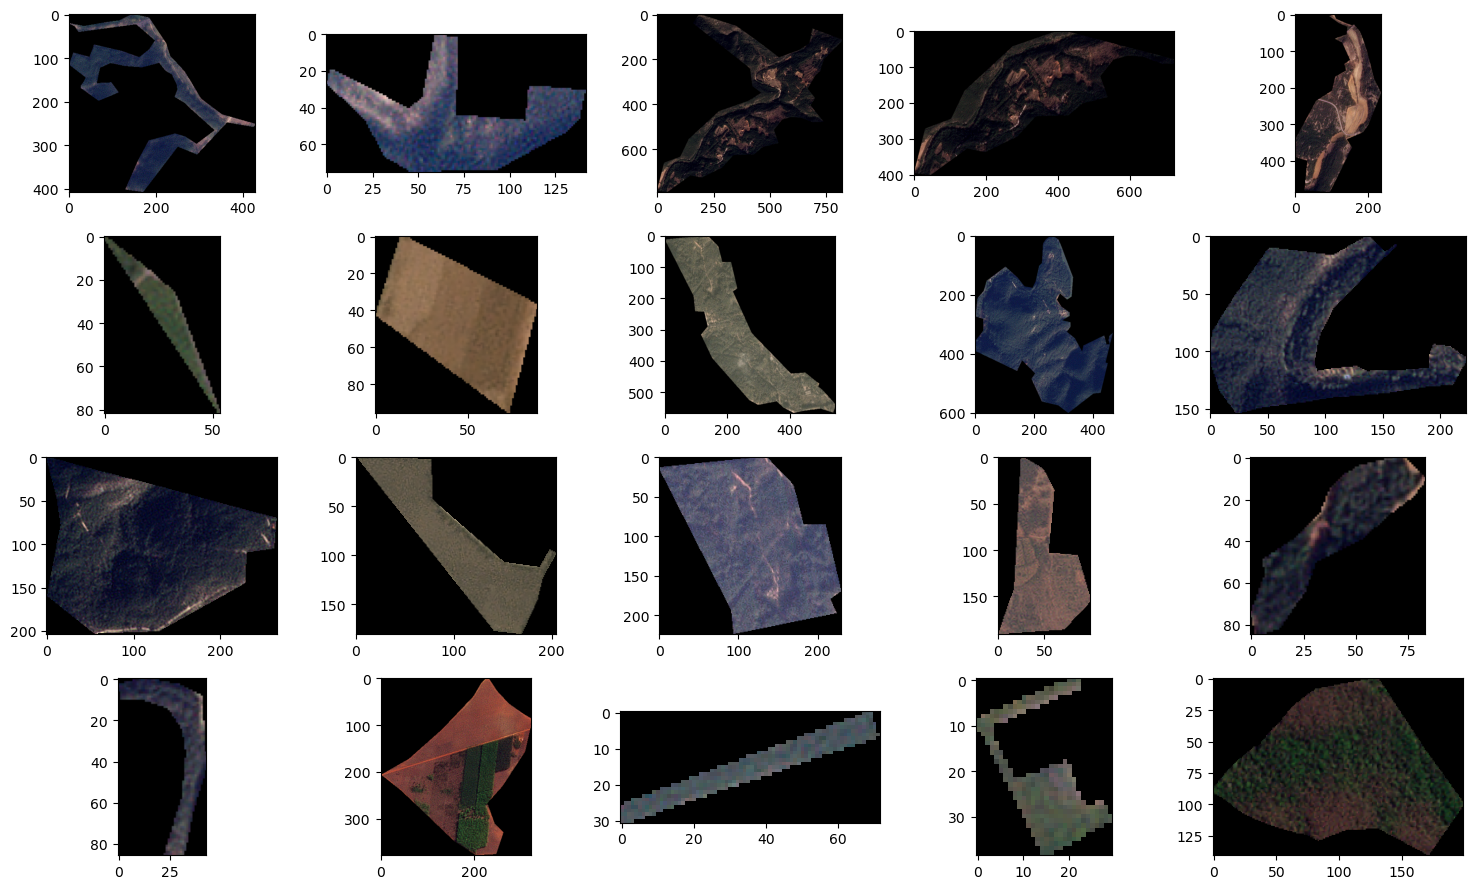

In [10]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

# Directory path
dir_path = "/home/idisc02/Saarland_Forest_monitoring_research/Forest_Monitoring/input/Tree_Nation_Polygons/tree_nation_small_size_polygons/Intercharge_polygons_geo/sample_tree_nation_data"

# Get all .tif files in the directory
tif_files = [f for f in os.listdir(dir_path) if f.endswith('.tif')]

# Tolerance level for dark pixels
tolerance = 50

# Create a figure and axes with a grid of 3 rows and 5 columns
fig, axs = plt.subplots(4, 5, figsize=(15, 9))

# Only process the first 15 images
for i, tif_file in enumerate(tif_files[:20]):
    image_path = os.path.join(dir_path, tif_file)
    image_array = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)

    # Create a mask for dark pixels
    mask = np.all(image_array < tolerance, axis=-1)

    # Find the bounding box of the non-dark regions
    coords = np.argwhere(~mask)
    x_min, y_min = coords.min(axis=0)
    x_max, y_max = coords.max(axis=0)

    # Crop the image to this bounding box
    cropped_image_array = image_array[x_min:x_max+1, y_min:y_max+1]

    # Calculate the row and column index for the subplot
    row = i // 5
    col = i % 5

    # Display the cropped image in the corresponding subplot
    axs[row, col].imshow(cropped_image_array)

# Remove any empty subplots
for i in range(len(tif_files), 15):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()